In [1]:
from copy import deepcopy

import jax.numpy as jnp
import numpy as np
import jax

from jax import grad, jit, vmap, pmap

from jax import lax

from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

In [2]:
class Counter:
    def __init__(self):
        self.n = 0
    def count(self):
        self.n += 1
        return self.n
    def reset(self):
        self.n = 0

counter = Counter()

for _ in range(3):
    print(counter.count())

1
2
3


In [3]:
# does not work, will cache just 1
counter.reset()
fast_count = jit(counter.count)

for _ in range(3):
    print(fast_count())

1
1
1


In [4]:
counter.reset()
make_jaxpr(counter.count)()

{ lambda ; . let  in (1,) }

In [5]:
CounterState = int

class CounterV2:
    def count(self, n: CounterState):
        return n+1, n+1
    def reset(self):
        return 0

In [6]:
counter = CounterV2()
state = counter.reset()

for _ in range(3):
    value, state = counter.count(state)
    print(value)

1
2
3


In [7]:
state = counter.reset()
fast_count = jit(counter.count)

for _ in range(3):
    value, state = fast_count(state)
    print(value)

1
2
3


In [8]:
# class Stateful:
#     state: State
#     def stateful_method(*arg, **kwarg) -> Output:
#         ...

# to

# class Stateless
# def stateless_method(state: State, *args, **kwargs) -> (Output, State):
#     ...

## PyTree

In [9]:
pytree_ex = [
    [1, "a", object()],
    (1, (2, 3), ()),
    [1, {"k1": 2, "k2": (3, 4)}, 5],
    {"a": 2, "b": (2, 3)},
    jnp.array([1, 2, 3])
]

In [10]:
for pytree in pytree_ex:
    leaves = jax.tree_util.tree_leaves(pytree)
    print(leaves)

[1, 'a', <object object at 0x12fcb9080>]
[1, 2, 3]
[1, 2, 3, 4, 5]
[2, 2, 3]
[Array([1, 2, 3], dtype=int32)]


In [11]:
list_of_lists = [
    {"a": 3},
    [1, 2, 3],
    [1, 2],
    [1, 2, 3 ,4]
]

In [12]:
jax.tree_map(lambda x: x**2, list_of_lists)

[{'a': 9}, [1, 4, 9], [1, 4], [1, 4, 9, 16]]

In [13]:
another = deepcopy(list_of_lists)
jax.tree_map(lambda x, y: x * y, list_of_lists, another)

[{'a': 9}, [1, 4, 9], [1, 4], [1, 4, 9, 16]]

In [14]:
# need same structure
another.append([23])
jax.tree_map(lambda x, y: x * y, list_of_lists, another)

ValueError: List arity mismatch: 5 != 4; list: [{'a': 3}, [1, 2, 3], [1, 2], [1, 2, 3, 4], [23]].

## Basic MLP

In [15]:
def init_mlp_params(layers_width):
    params = []

    for n_in, n_out in zip(layers_width[:-1], layers_width[1:]):
        params.append(
            {
                "weights": np.random.normal(size=(n_in, n_out)) * np.sqrt(2 / n_in),
                "biases": np.ones(shape=(n_out,)),
            }
        )
    return params

params = init_mlp_params([1, 128, 128, 1])

jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [16]:
def forward(params, x):
    *hidden, last = params

    for layer in hidden:
        x = jax.nn.relu(jnp.dot(x, layer["weights"] + layer["biases"]))

    return jnp.dot(x, last["weights"] + last["biases"])

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)

lr = 0.01

@jit
def update(params, x, y):
    grads = jax.grad(loss_fn)(params, x, y)

    return jax.tree_map(lambda p, g: p - lr * g, params, grads)

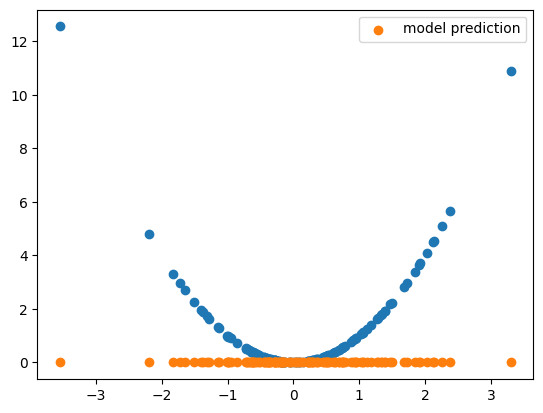

In [17]:
xs = np.random.normal(size=(128, 1))
ys = xs ** 2

num_epochs = 5000
for _ in range(num_epochs):
    params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label="model prediction")
plt.legend()

## Custom PyTrees

In [18]:
class MyContainer:
    def __init__(self, name, a, b, c):
        self.name = name
        self.a = a
        self.b = b
        self.c = c

In [19]:
example_pytree = [MyContainer("a", 1, 2, 3), MyContainer("b", 2, 3, 4)]

In [20]:
jax.tree_map(lambda x: x + 1, example_pytree)

TypeError: unsupported operand type(s) for +: 'MyContainer' and 'int'

In [21]:
def flatten(container):
    return [container.a, container.b, container.c], container.name

def unflatten(aux_data, flat_contents):
    return MyContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_node(MyContainer, flatten, unflatten)

In [22]:
jax.tree_util.tree_leaves(jax.tree_map(lambda x: x + 1, example_pytree))

[2, 3, 4, 3, 4, 5]

In [23]:
zeros_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]
print(zeros_tree)

shapes = jax.tree_map(lambda x: x.shape, zeros_tree)
print(shapes)

ones_tree = jax.tree_map(jnp.ones, shapes)
print(ones_tree)

[Array([[0., 0., 0.],
       [0., 0., 0.]], dtype=float32), Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)]
[(2, 3), (3, 4)]
[(Array([1., 1.], dtype=float32), Array([1., 1., 1.], dtype=float32)), (Array([1., 1., 1.], dtype=float32), Array([1., 1., 1., 1.], dtype=float32))]


In [24]:
zeros_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]
print(zeros_tree)

shapes = jax.tree_map(lambda x: jnp.array(x.shape), zeros_tree)
print(shapes)

ones_tree = jax.tree_map(jnp.ones, shapes)
print(ones_tree)

[Array([[0., 0., 0.],
       [0., 0., 0.]], dtype=float32), Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)]
[Array([2, 3], dtype=int32), Array([3, 4], dtype=int32)]
[Array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32), Array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)]


## value_and_grad and has_aux

In [25]:
def sum_squared_error(x, y):
    return sum((x - y) ** 2)

x = jnp.arange(4, dtype=jnp.float32)
y = x + 0.1

x, jax.value_and_grad(sum_squared_error)(x, y)

(Array([0., 1., 2., 3.], dtype=float32),
 (Array(0.03999997, dtype=float32),
  Array([-0.2       , -0.20000005, -0.19999981, -0.19999981], dtype=float32)))

In [26]:
def sum_squared_error(x, y):
    return sum((x - y) ** 2), x - y

jax.grad(sum_squared_error, has_aux=True)(x, y)

(Array([-0.2       , -0.20000005, -0.19999981, -0.19999981], dtype=float32),
 Array([-0.1       , -0.10000002, -0.0999999 , -0.0999999 ], dtype=float32))